In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
α = .05

import wrangle as wr
from stats_toolkit import significance_test

from env import get_db_url

taxvaluedollarcount is what the county assessor is saying the house is worth for tax purposes

# <span style='color:red'> Questions and Key Considerations: </span>
## - Acquire:
- <span style='color:blue'>The taxvaluedollarcnt is a valuation assigned by a tax assessor for the county's tax purposes __not__ a sale amount</span>
- I am leaving taxamount for the sake of exploration, but it needs to be removed before modeling.

## - Wrangle:
- <span style='color:red'>I used Pearson's R to test the significance of the relationship between the year a home was constructed and the square footage. Am I correct in thinking that these things would both be continuous?</span>

# Acquiring Data:
- Acquiring data for *single family homes* that have transaction dates *during the year of 2017.*

In [2]:
query_df = wr.get_zillow_data()

In [3]:
#query_df['bed_bath_ratio'] = df.bedroomcnt / df.bathroomcnt

In [4]:
#Verifying that the dataset meets the rubric requirement of being 52,441 homes long:
query_df.shape[0] / 52441

1.0

In [5]:
query_df[query_df.value != (query_df.land_value + query_df.structure_value)].shape[0]

84

In [6]:
query_df.head()

,bathrooms,bedrooms,value,square_feet,year_built,fips,latitude,longitude,lot_size,zip_code,structure_value,land_value
0,3.5,4.0,1023282.0,3100.0,1998.0,6059.0,33634931.0,-117869207.0,4506.0,96978.0,485713.0,537569.0
1,1.0,2.0,464000.0,1465.0,1967.0,6111.0,34449266.0,-119281531.0,12647.0,97099.0,88000.0,376000.0
2,2.0,3.0,564778.0,1243.0,1962.0,6059.0,33886168.0,-117823170.0,8432.0,97078.0,85289.0,479489.0
3,3.0,4.0,145143.0,2376.0,1970.0,6037.0,34245180.0,-118240722.0,13038.0,96330.0,108918.0,36225.0
4,3.0,4.0,773303.0,2962.0,1950.0,6037.0,34145202.0,-118179824.0,63000.0,96293.0,276684.0,496619.0


swap these

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

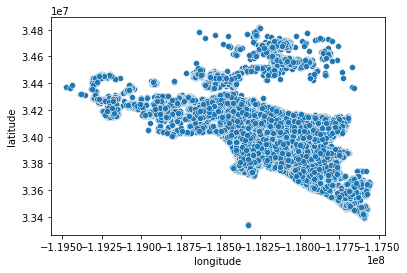

In [7]:
sns.scatterplot(data = query_df, x = query_df.longitude, y = query_df.latitude)

## Wrangling Data:
- General Data Format Cleaning:
    - Converting moving decimal left 6 places on latitude and longitude.
- Assigning county names to each home, based on the fips code one the record:
    - 60370: Los Angeles County
    - 60490: Orange County
    - 61110: Ventura County
- Homes Dropped:
    - 0 bedrooms
    - 0 bathrooms
    - Less than 120 square feet
    - More than 10,000 square feet
    - Home value over \\$1.6 million
    - Records containing null values
- Columns Created:
    - Column displaying the ratios of bedrooms to bathrooms.
- This, paired with the other operations and cleaning carried out in the wrangle script, leave 95.4\% of the data remaining. 
- I feel comfortable with the omission of this data, as I want to ensure that I'm not excluding too large a chunk of my total set, but do want to be sure that I'm focusing my model on homes that comprise the bulk of Zillow's business. Homes priced in the millions are very clearly not the main focus of Zillow's model, so I don't want to skew it's training by including too many of those. See plot below.

In [8]:
#Acquiring CLEANED data, beyond the initial SQL query:
df = wr.wrangle_zillow()

In [9]:
#Verifying how much of the data was cleaned out (less than 5%):
df.shape[0] / query_df.shape[0]

0.9471405960984726

In [10]:
# splitting the data into train, validate, and test sets before exploration:
train, validate, test = wr.split_zillow_data(df)

# Exploring Data:

## Early Hypotheses:
- More square footage will lead to more value.
- Homes with more land will have more value.
- Location will have a significant impact on value.
- More bedrooms and more bathrooms will lead to more value.
- There will be a relationship between the bath-to-bed ratio and price.
    - Homes with higher bath-to-bed ratios will fetch higher prices.
- Newer houses will fetch more value and be sold less.

## Key Questions Answered:
- Is there a relationship between the county in which a home is built and its value?
- Is there a relationship between the year a home is built and the square footage of a home?

In [11]:
train.head()

,bathrooms,bedrooms,value,square_feet,year_built,latitude,longitude,lot_size,zip_code,structure_value,land_value,county,bath_bed_ratio
10503,4.0,5,525269.0,2664.0,1954,34.216195,-118.412888,25222.0,96450.0,238249.0,287020.0,Los Angeles County,0.800000
20093,3.0,4,243471.0,2201.0,1990,34.555259,-118.094324,6280.0,97328.0,197173.0,46298.0,Los Angeles County,0.750000
9071,3.0,4,750594.0,2730.0,1964,34.204889,-118.158852,20413.0,96265.0,206683.0,543911.0,Los Angeles County,0.750000
33092,2.0,4,464221.0,1991.0,1952,33.798432,-118.103808,6318.0,96247.0,173956.0,290265.0,Los Angeles County,0.500000
45363,2.0,3,341185.0,944.0,1949,34.091857,-118.199044,4872.0,96012.0,109038.0,232147.0,Los Angeles County,0.666667


## Visualizing the distribution of homes by price within the train set: 

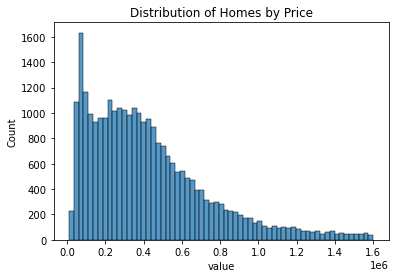

In [12]:
sns.histplot(data = train, x = train.value).set(title = 'Distribution of Homes by Price');

## Visualizing Distribution of Homes by Square Footage:

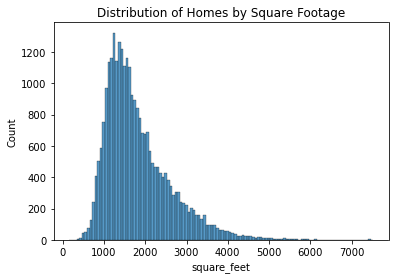

In [13]:
sns.histplot(data = train, x = train.square_feet).set(title = 'Distribution of Homes by Square Footage');

## Visualizing Distribution of Homes by Bedroom Count:

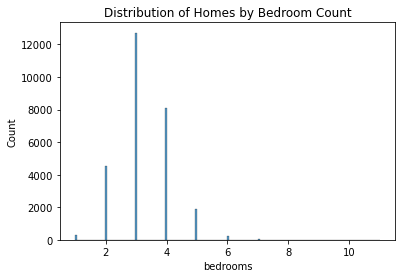

In [14]:
sns.histplot(data = train, x = train.bedrooms).set(title = 'Distribution of Homes by Bedroom Count');

## Visualizing Distribution of Homes by Bathroom Count:

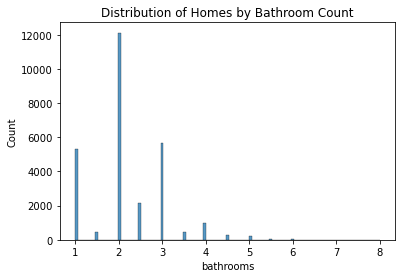

In [15]:
sns.histplot(data = train, x = train.bathrooms).set(title = 'Distribution of Homes by Bathroom Count');

## Visualizing Home Value by Ratio of Bathrooms to Bedrooms:

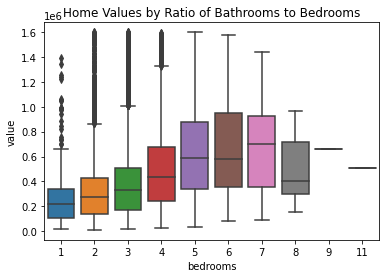

In [16]:
sns.boxplot(data = train, x = train.bedrooms, y = train.value ).set(title = 'Home Values by Ratio of Bathrooms to Bedrooms');

## Visualizing Home Values by County:

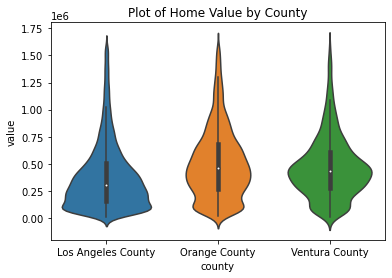

In [17]:
sns.violinplot(data = train, x = train.county, y = train.value ).set(title = 'Plot of Home Value by County');

### Stats: Does County of Residence Have a Meaningful Impact on Value?
- Null Hypothesis: There is no relationship between county and home value.
- Alternative Hypothesis: There is a significant relationship between county and home value.
- __Findings: There is sufficient evidence to reject the null and assert that there is a meaningful relationship between home values and county.__

In [25]:
#Creating Separate DataFrames by County:
la_values = train[train.county == 'Los Angeles County'].value
orange_values = train[train.county == 'Orange County'].value
ventura_values = train[train.county == 'Ventura County'].value

#Running a one-way ANOVA (there is a single independent variable - 'county'):
f, p = stats.f_oneway(la_values, orange_values, ventura_values)

#Printing whether the p-value is less than alpha:
significance_test(p), p

Sufficient evidence -> Reject the null hypothesis.


(None, 2.037937164490527e-198)

## Number of Homes for Sale by County:

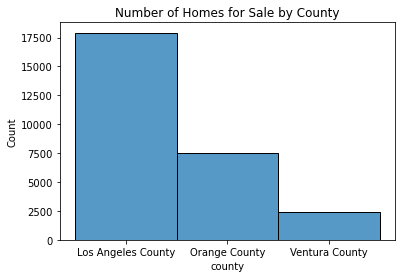

In [19]:
sns.histplot(data = train, x = train.county).set(title = 'Number of Homes for Sale by County');

## Distribution of Homes by Year Built:

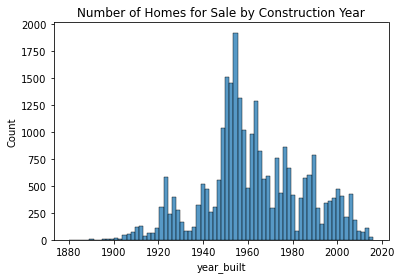

In [20]:
sns.histplot(data = train, x = train.year_built).set(title = 'Number of Homes for Sale by Construction Year');

## The Relationship Between the Year a Home Was Built and the Square Footage:

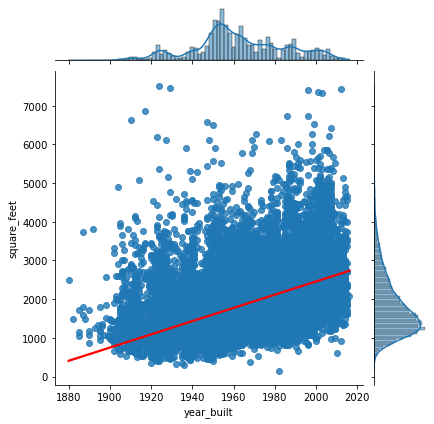

In [21]:
sns.jointplot(x = "year_built", y = "square_feet", data = train, kind = 'reg',
                  joint_kws = {'line_kws':{'color':'red'}});

### Stats: Is there a relationship between the year a home was built and the square footage?
- Null Hypothesis: There is no relationship between the year a home was built and the square footage.
- Alternative Hypothesis: There is a significant relationship between the year a home was built and the square footage.
- __Findings: There is sufficient evidence to reject the null and assert that there is a meaningful relationship between construction year and square footage.__ 
    - It appears that as time has progressed, homes are being built larger.

In [27]:
#Running a Pearson's R test to check the correlation between year built and square footage in a home:
corr, p = stats.pearsonr(train.square_feet, train.year_built)
#Running a significance test to determine whether we can reject the null:
corr, significance_test(p)"Di"

Sufficient evidence -> Reject the null hypothesis.


(0.48518230146550184, None)

# Modeling: